In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/DaLiac'

In [3]:
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 196 (delta 90), reused 182 (delta 83), pack-reused 0
Receiving objects: 100% (196/196), 64.83 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (90/90), done.


---

In [4]:
import os 
from datetime import date
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import pandas as pd
import json
import pickle

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

import numpy.random as random
from src.datasets.data import SPReader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-25988acebc6a>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "SOTAEmbedding",
    "model_params":{
        "linear_filters":[1024,1024,1024,400],
        "input_feat":36,
        "dropout":0.1,
    },
    "folding": True,
    "lr": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 64,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [6]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [7]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = SPReader(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14


FileNotFoundError: ignored

In [ ]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [ ]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

In [ ]:
emb = model(torch.randn((32,36)))
emb.size()

torch.Size([32, 2048])

In [ ]:
emb

tensor([[0.0000, 0.9450, 0.0000,  ..., 0.2377, 0.0000, 0.2170],
        [0.0000, 1.0629, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.7470,  ..., 0.0000, 0.6727, 0.0000],
        ...,
        [0.4974, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0432, 0.0000,  ..., 0.2271, 0.0000, 0.0000],
        [0.5727, 0.7478, 1.8209,  ..., 0.7224, 0.7648, 1.3174]],
       grad_fn=<ReluBackward0>)

In [ ]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

  

In [ ]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [ ]:
video_feat.shape

(18, 2048)

In [ ]:
vid_cls_name = np.unique(video_classes)

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassFeatures(self):
      cls_feat = []
      for cls in self.action_classes:
          idx = self.attribute_dict[cls]
          cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

      cls_feat = torch.vstack(cls_feat)
      return cls_feat

---

In [ ]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [ ]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [ ]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [ ]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [ ]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((16752, 36), (4189, 36), (5608, 36))

In [ ]:
def loss_cross_entropy(
        y_pred:torch.Tensor,
        cls:torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="sum")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    #print(loss)
    return loss

def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

def predict_class(
        y_pred:torch.Tensor,
        selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [ ]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [ ]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

In [ ]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

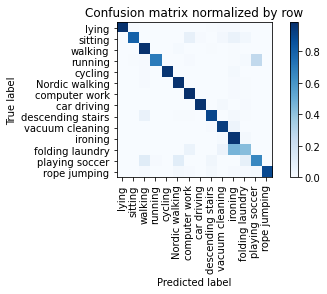

Overall accuracy: 0.903

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.931      0.982      0.956      0.151        628|	 ironing: 0.008,	folding laundry: 0.005,	
          walking       0.929      0.974      0.951      0.111        460|	 Nordic walking: 0.015,	ironing: 0.004,	
          ironing       0.742      0.962      0.838      0.107        445|	 folding laundry: 0.020,	vacuum cleaning: 0.013,	
            lying       1.000      0.971      0.985      0.091        377|	 vacuum cleaning: 0.011,	ironing: 0.008,	
   Nordic walking       0.946      0.971      0.958      0.090        376|	 ironing: 0.011,	walking: 0.008,	
          sitting       0.979      0.791      0.875      0.085        354|	 computer work: 0.079,	ironing: 0.065,	
  vacuum cleaning       0.903      0.932      0.918      0.082        340|	 ironing: 0.047,	descending stairs: 0.009,	
          cycling       0.997      0.963      0.979      0.077  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

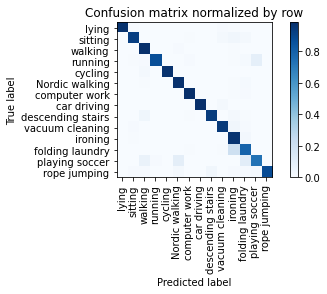

Overall accuracy: 0.945

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.989      0.984      0.986      0.150        626|	 folding laundry: 0.008,	ironing: 0.005,	
          walking       0.947      0.980      0.963      0.110        457|	 Nordic walking: 0.011,	ironing: 0.004,	
          ironing       0.852      0.966      0.905      0.107        446|	 folding laundry: 0.027,	sitting: 0.004,	
            lying       1.000      0.971      0.985      0.092        382|	 vacuum cleaning: 0.010,	ironing: 0.005,	
   Nordic walking       0.955      0.973      0.964      0.090        373|	 folding laundry: 0.013,	ironing: 0.005,	
          sitting       0.965      0.924      0.944      0.086        356|	 ironing: 0.034,	folding laundry: 0.020,	
  vacuum cleaning       0.955      0.944      0.950      0.082        341|	 ironing: 0.032,	folding laundry: 0.009,	
          cycling       1.000      0.969      0.984      0.077  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

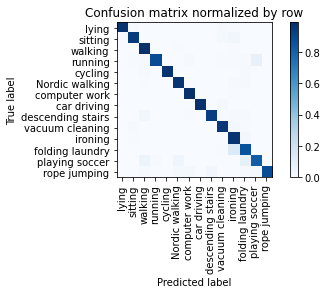

Overall accuracy: 0.955

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.987      0.987      0.987      0.150        626|	 ironing: 0.005,	folding laundry: 0.003,	
          walking       0.954      0.987      0.970      0.111        460|	 Nordic walking: 0.007,	ironing: 0.004,	
          ironing       0.876      0.971      0.921      0.107        445|	 folding laundry: 0.025,	sitting: 0.004,	
            lying       1.000      0.971      0.985      0.091        379|	 vacuum cleaning: 0.011,	sitting: 0.008,	
   Nordic walking       0.976      0.971      0.973      0.090        375|	 folding laundry: 0.008,	ironing: 0.008,	
          sitting       0.963      0.944      0.953      0.085        355|	 ironing: 0.034,	vacuum cleaning: 0.020,	
  vacuum cleaning       0.947      0.953      0.950      0.081        339|	 ironing: 0.029,	sitting: 0.009,	
          cycling       1.000      0.972      0.986      0.077        31

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

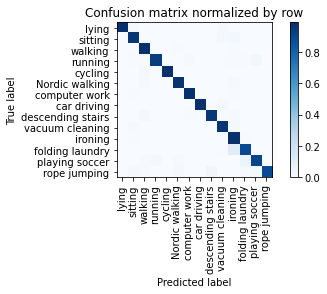

Overall accuracy: 0.966

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.994      0.986      0.990      0.150        623|	 ironing: 0.005,	sitting: 0.005,	
          walking       0.964      0.982      0.973      0.110        457|	 ironing: 0.007,	Nordic walking: 0.007,	
          ironing       0.898      0.987      0.940      0.107        445|	 folding laundry: 0.007,	sitting: 0.004,	
            lying       1.000      0.976      0.988      0.092        381|	 sitting: 0.010,	vacuum cleaning: 0.008,	
   Nordic walking       0.984      0.971      0.977      0.090        375|	 ironing: 0.011,	walking: 0.011,	
          sitting       0.950      0.958      0.954      0.085        355|	 ironing: 0.025,	vacuum cleaning: 0.017,	
  vacuum cleaning       0.956      0.965      0.960      0.082        340|	 ironing: 0.021,	sitting: 0.009,	
          cycling       1.000      0.981      0.991      0.077        322|	 walking: 0.0

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

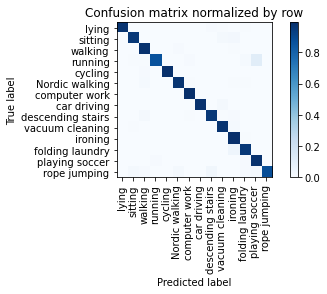

Overall accuracy: 0.969

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.990      0.990      0.150        626|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.968      0.983      0.975      0.110        459|	 Nordic walking: 0.009,	ironing: 0.004,	
          ironing       0.934      0.989      0.961      0.107        447|	 folding laundry: 0.004,	descending stairs: 0.002,	
            lying       1.000      0.974      0.987      0.092        382|	 descending stairs: 0.010,	folding laundry: 0.005,	
   Nordic walking       0.984      0.971      0.977      0.091        377|	 walking: 0.013,	folding laundry: 0.005,	
          sitting       0.974      0.957      0.965      0.084        349|	 ironing: 0.026,	vacuum cleaning: 0.017,	
  vacuum cleaning       0.962      0.973      0.968      0.081        338|	 ironing: 0.015,	sitting: 0.006,	
          cycling       1.000      0.985      0.992      0.0

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

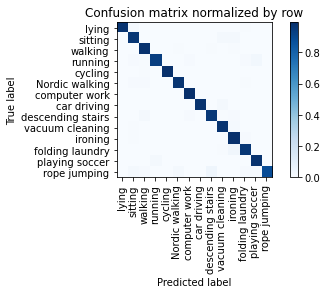

Overall accuracy: 0.974

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.989      0.992      0.990      0.151        628|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.976      0.983      0.979      0.110        459|	 Nordic walking: 0.007,	ironing: 0.004,	
          ironing       0.944      0.984      0.964      0.108        448|	 folding laundry: 0.009,	sitting: 0.004,	
            lying       1.000      0.974      0.987      0.091        380|	 sitting: 0.016,	folding laundry: 0.005,	
   Nordic walking       0.986      0.971      0.978      0.090        374|	 walking: 0.011,	sitting: 0.008,	
          sitting       0.944      0.963      0.954      0.085        353|	 ironing: 0.020,	vacuum cleaning: 0.017,	
  vacuum cleaning       0.968      0.973      0.971      0.081        338|	 ironing: 0.015,	sitting: 0.006,	
          cycling       1.000      0.988      0.994      0.077        322|	 walking: 0.0

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

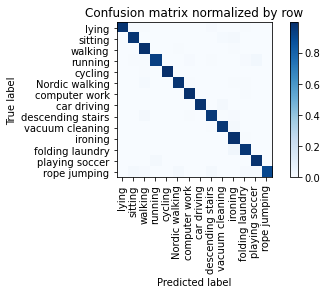

Overall accuracy: 0.975

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.989      0.990      0.151        627|	 folding laundry: 0.005,	ironing: 0.003,	
          walking       0.966      0.987      0.976      0.111        460|	 Nordic walking: 0.007,	ironing: 0.004,	
          ironing       0.940      0.989      0.964      0.107        446|	 folding laundry: 0.007,	descending stairs: 0.002,	
            lying       1.000      0.974      0.987      0.091        380|	 descending stairs: 0.008,	folding laundry: 0.005,	
   Nordic walking       0.986      0.971      0.978      0.090        375|	 walking: 0.013,	folding laundry: 0.005,	
          sitting       0.974      0.969      0.972      0.085        354|	 ironing: 0.017,	vacuum cleaning: 0.014,	
  vacuum cleaning       0.976      0.965      0.970      0.082        340|	 ironing: 0.021,	descending stairs: 0.006,	
          cycling       1.000      0.994  

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

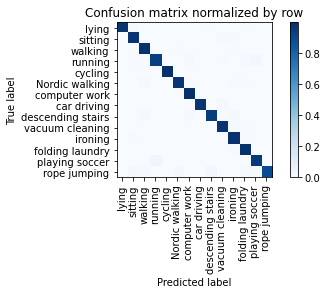

Overall accuracy: 0.977

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.989      0.992      0.990      0.151        627|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.978      0.989      0.984      0.109        454|	 ironing: 0.004,	Nordic walking: 0.004,	
          ironing       0.957      0.987      0.971      0.107        446|	 folding laundry: 0.007,	sitting: 0.007,	
            lying       1.000      0.974      0.987      0.091        380|	 sitting: 0.011,	folding laundry: 0.005,	
   Nordic walking       0.989      0.971      0.980      0.090        376|	 walking: 0.011,	folding laundry: 0.005,	
          sitting       0.958      0.975      0.966      0.085        353|	 vacuum cleaning: 0.014,	ironing: 0.011,	
  vacuum cleaning       0.971      0.974      0.972      0.082        341|	 ironing: 0.015,	folding laundry: 0.006,	
          cycling       1.000      0.997      0.998      0.078        32

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

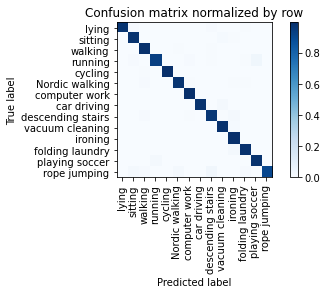

Overall accuracy: 0.980

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.990      0.991      0.150        626|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.981      0.987      0.984      0.111        460|	 descending stairs: 0.007,	Nordic walking: 0.004,	
          ironing       0.961      0.993      0.977      0.107        447|	 folding laundry: 0.002,	descending stairs: 0.002,	
            lying       1.000      0.973      0.987      0.091        377|	 descending stairs: 0.011,	sitting: 0.008,	
   Nordic walking       0.989      0.973      0.981      0.090        376|	 walking: 0.011,	folding laundry: 0.005,	
          sitting       0.969      0.980      0.975      0.085        352|	 vacuum cleaning: 0.014,	ironing: 0.006,	
  vacuum cleaning       0.974      0.985      0.979      0.081        339|	 ironing: 0.012,	sitting: 0.003,	
          cycling       1.000      0.994      0.997      0

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

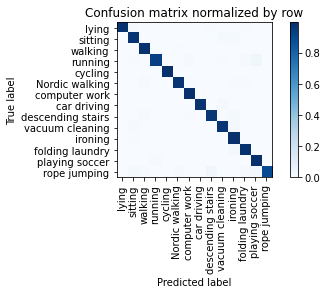

Overall accuracy: 0.978

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.994      0.993      0.150        624|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.981      0.985      0.983      0.111        462|	 Nordic walking: 0.006,	ironing: 0.004,	
          ironing       0.948      0.993      0.970      0.106        442|	 sitting: 0.005,	folding laundry: 0.002,	
            lying       1.000      0.979      0.989      0.092        381|	 sitting: 0.008,	folding laundry: 0.005,	
   Nordic walking       0.989      0.973      0.981      0.090        376|	 walking: 0.011,	folding laundry: 0.005,	
          sitting       0.961      0.972      0.966      0.084        351|	 ironing: 0.014,	vacuum cleaning: 0.014,	
  vacuum cleaning       0.974      0.968      0.971      0.082        342|	 ironing: 0.018,	sitting: 0.009,	
          cycling       1.000      0.994      0.997      0.077        322|	 walk

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

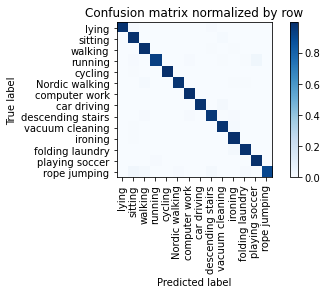

Overall accuracy: 0.980

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.994      0.993      0.150        622|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.981      0.989      0.985      0.111        460|	 ironing: 0.004,	descending stairs: 0.004,	
          ironing       0.961      0.993      0.977      0.107        446|	 sitting: 0.007,	rope jumping: 0.000,	
            lying       1.000      0.976      0.988      0.092        381|	 sitting: 0.010,	descending stairs: 0.008,	
   Nordic walking       0.995      0.973      0.984      0.090        376|	 walking: 0.013,	folding laundry: 0.005,	
          sitting       0.951      0.983      0.967      0.085        355|	 vacuum cleaning: 0.014,	ironing: 0.003,	
  vacuum cleaning       0.974      0.977      0.975      0.082        341|	 ironing: 0.015,	sitting: 0.006,	
          cycling       1.000      0.994      0.997      0.077        321|	 si

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

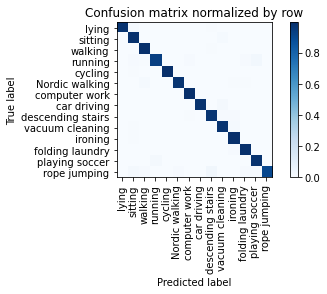

Overall accuracy: 0.981

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.995      0.992      0.994      0.150        625|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.985      0.991      0.988      0.110        457|	 descending stairs: 0.004,	ironing: 0.002,	
          ironing       0.967      0.993      0.980      0.108        448|	 sitting: 0.004,	folding laundry: 0.002,	
   Nordic walking       0.995      0.974      0.984      0.091        378|	 walking: 0.013,	folding laundry: 0.005,	
            lying       1.000      0.976      0.988      0.091        378|	 sitting: 0.013,	descending stairs: 0.005,	
          sitting       0.951      0.986      0.968      0.084        351|	 vacuum cleaning: 0.014,	rope jumping: 0.000,	
  vacuum cleaning       0.971      0.977      0.974      0.082        341|	 ironing: 0.015,	sitting: 0.006,	
          cycling       1.000      0.994      0.997      0.077        

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

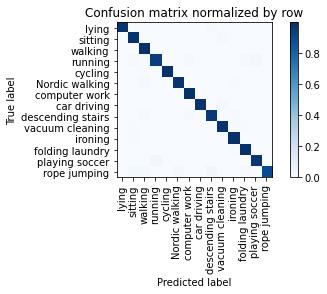

Overall accuracy: 0.981

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.994      0.992      0.993      0.151        627|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.972      0.996      0.984      0.110        457|	 ironing: 0.002,	descending stairs: 0.002,	
          ironing       0.972      0.996      0.983      0.107        446|	 sitting: 0.004,	rope jumping: 0.000,	
            lying       1.000      0.979      0.989      0.091        379|	 descending stairs: 0.011,	sitting: 0.005,	
   Nordic walking       0.995      0.973      0.984      0.091        377|	 walking: 0.016,	ironing: 0.005,	
          sitting       0.964      0.986      0.975      0.085        353|	 vacuum cleaning: 0.014,	rope jumping: 0.000,	
  vacuum cleaning       0.974      0.976      0.975      0.082        340|	 ironing: 0.012,	folding laundry: 0.006,	
          cycling       1.000      0.994      0.997      0.077        322

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

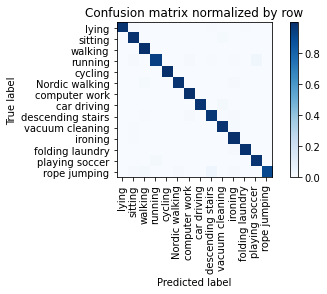

Overall accuracy: 0.982

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.994      0.993      0.151        627|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.978      0.993      0.986      0.110        457|	 ironing: 0.002,	descending stairs: 0.002,	
          ironing       0.961      0.996      0.978      0.107        447|	 sitting: 0.004,	rope jumping: 0.000,	
            lying       1.000      0.979      0.989      0.091        379|	 folding laundry: 0.005,	descending stairs: 0.005,	
   Nordic walking       0.995      0.976      0.985      0.090        375|	 walking: 0.013,	ironing: 0.008,	
          sitting       0.969      0.986      0.978      0.085        353|	 vacuum cleaning: 0.014,	rope jumping: 0.000,	
  vacuum cleaning       0.977      0.977      0.977      0.082        341|	 ironing: 0.015,	sitting: 0.006,	
          cycling       1.000      0.997      0.998      0.078        323

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

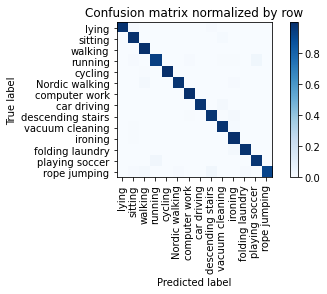

Overall accuracy: 0.982

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.994      0.994      0.994      0.150        625|	 ironing: 0.003,	sitting: 0.003,	
          walking       0.976      0.996      0.986      0.110        457|	 ironing: 0.002,	descending stairs: 0.002,	
          ironing       0.959      0.996      0.977      0.107        447|	 sitting: 0.004,	rope jumping: 0.000,	
            lying       1.000      0.976      0.988      0.092        381|	 descending stairs: 0.008,	sitting: 0.008,	
   Nordic walking       0.997      0.973      0.985      0.090        375|	 walking: 0.016,	ironing: 0.008,	
          sitting       0.967      0.986      0.976      0.085        355|	 vacuum cleaning: 0.014,	rope jumping: 0.000,	
  vacuum cleaning       0.973      0.976      0.975      0.081        337|	 ironing: 0.015,	sitting: 0.006,	
          cycling       1.000      0.994      0.997      0.078        323|	 walki

unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

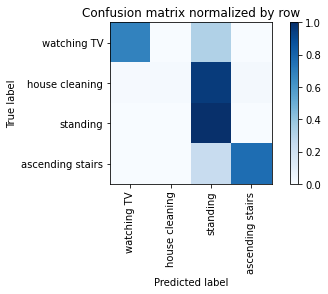

Overall accuracy: 0.583

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       1.000      0.015      0.029      0.330       1835|	 standing: 0.954,	ascending stairs: 0.022,	
        standing       0.448      1.000      0.618      0.329       1834|	 ascending stairs: 0.000,	house cleaning: 0.000,	
ascending stairs       0.954      0.765      0.849      0.193       1075|	 standing: 0.235,	house cleaning: 0.000,	
     watching TV       0.969      0.683      0.801      0.148        824|	 standing: 0.317,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.804      0.583      0.496        1.0       5568|	      

{'accuracy': 0.5829741379310345, 'precision': 0.8425376509227712, 'recall': 0.6156543716082323, 'f1': 0.5743752298470133}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'des

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

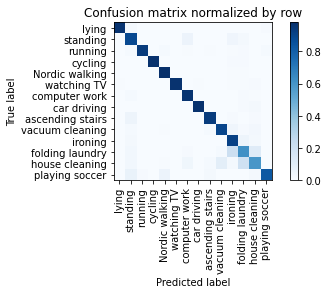

Overall accuracy: 0.890

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.935      0.964      0.949      0.140        581|	 standing: 0.014,	folding laundry: 0.010,	
         ironing       0.810      0.915      0.859      0.102        424|	 folding laundry: 0.050,	house cleaning: 0.017,	
  house cleaning       0.825      0.590      0.688      0.096        398|	 folding laundry: 0.198,	vacuum cleaning: 0.098,	
           lying       0.992      0.965      0.978      0.089        370|	 standing: 0.016,	playing soccer: 0.011,	
        standing       0.838      0.883      0.860      0.088        368|	 computer work: 0.054,	ironing: 0.041,	
  Nordic walking       0.964      0.981      0.972      0.087        360|	 folding laundry: 0.006,	ironing: 0.006,	
 vacuum cleaning       0.873      0.899      0.886      0.083        345|	 ironing: 0.041,	house cleaning: 0.023,	
         cycling       0.997      0.972      0.984      0.

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

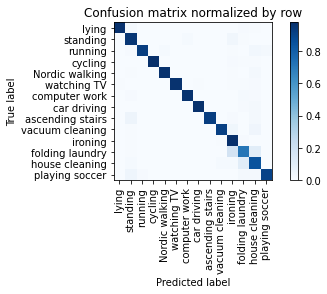

Overall accuracy: 0.933

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.989      0.964      0.976      0.140        581|	 folding laundry: 0.012,	standing: 0.010,	
         ironing       0.844      0.979      0.906      0.101        420|	 folding laundry: 0.010,	standing: 0.007,	
  house cleaning       0.838      0.848      0.843      0.097        402|	 folding laundry: 0.107,	vacuum cleaning: 0.015,	
        standing       0.893      0.949      0.920      0.089        369|	 ironing: 0.033,	computer work: 0.014,	
           lying       0.994      0.967      0.981      0.089        369|	 standing: 0.016,	folding laundry: 0.008,	
  Nordic walking       0.991      0.969      0.980      0.086        359|	 house cleaning: 0.017,	ironing: 0.006,	
 vacuum cleaning       0.975      0.916      0.945      0.083        344|	 house cleaning: 0.041,	ironing: 0.035,	
         cycling       1.000      0.978      0.989      0.076   

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

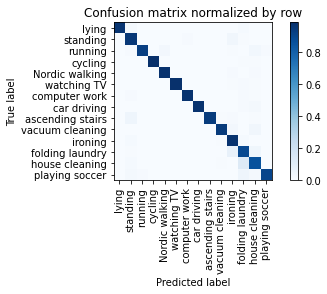

Overall accuracy: 0.947

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.993      0.972      0.982      0.138        575|	 folding laundry: 0.010,	standing: 0.010,	
         ironing       0.901      0.971      0.935      0.101        421|	 folding laundry: 0.012,	standing: 0.012,	
  house cleaning       0.896      0.854      0.875      0.097        404|	 folding laundry: 0.124,	standing: 0.012,	
        standing       0.903      0.951      0.927      0.089        371|	 ironing: 0.032,	computer work: 0.011,	
           lying       1.000      0.965      0.982      0.089        369|	 standing: 0.016,	folding laundry: 0.014,	
  Nordic walking       0.986      0.975      0.980      0.087        360|	 house cleaning: 0.011,	ironing: 0.008,	
 vacuum cleaning       0.982      0.939      0.960      0.083        345|	 house cleaning: 0.032,	ironing: 0.023,	
         cycling       1.000      0.984      0.992      0.076        31

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

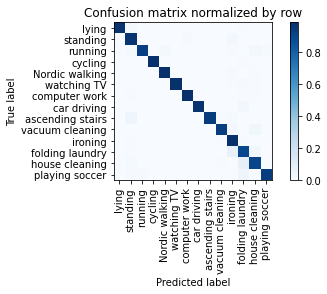

Overall accuracy: 0.956

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.995      0.979      0.987      0.139        579|	 folding laundry: 0.007,	standing: 0.007,	
         ironing       0.906      0.983      0.943      0.101        422|	 folding laundry: 0.005,	vacuum cleaning: 0.005,	
  house cleaning       0.914      0.903      0.909      0.097        402|	 folding laundry: 0.077,	standing: 0.012,	
           lying       1.000      0.970      0.985      0.089        369|	 standing: 0.019,	folding laundry: 0.005,	
        standing       0.915      0.965      0.939      0.088        368|	 ironing: 0.024,	computer work: 0.008,	
  Nordic walking       0.983      0.981      0.982      0.087        362|	 ironing: 0.008,	house cleaning: 0.006,	
 vacuum cleaning       0.982      0.930      0.955      0.083        344|	 house cleaning: 0.035,	ironing: 0.029,	
         cycling       1.000      0.984      0.992      0.076   

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

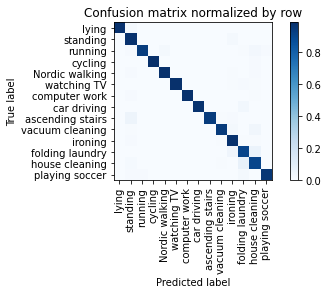

Overall accuracy: 0.958

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.998      0.979      0.989      0.139        580|	 standing: 0.010,	house cleaning: 0.005,	
         ironing       0.932      0.974      0.953      0.102        423|	 standing: 0.009,	folding laundry: 0.007,	
  house cleaning       0.899      0.901      0.900      0.097        404|	 folding laundry: 0.077,	standing: 0.012,	
        standing       0.900      0.976      0.937      0.089        371|	 ironing: 0.019,	folding laundry: 0.003,	
           lying       1.000      0.973      0.986      0.088        368|	 standing: 0.019,	playing soccer: 0.003,	
  Nordic walking       0.989      0.978      0.983      0.087        361|	 house cleaning: 0.008,	standing: 0.008,	
 vacuum cleaning       0.982      0.942      0.961      0.082        342|	 house cleaning: 0.032,	ironing: 0.020,	
         cycling       1.000      0.984      0.992      0.075        3

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

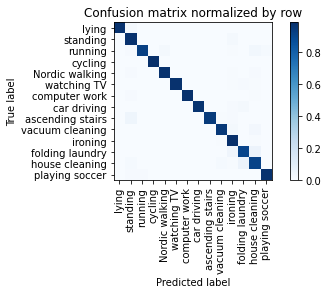

Overall accuracy: 0.962

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.998      0.981      0.990      0.139        579|	 standing: 0.010,	house cleaning: 0.005,	
         ironing       0.927      0.983      0.954      0.102        424|	 vacuum cleaning: 0.007,	house cleaning: 0.005,	
  house cleaning       0.906      0.913      0.910      0.097        402|	 folding laundry: 0.057,	vacuum cleaning: 0.012,	
        standing       0.912      0.976      0.943      0.090        373|	 ironing: 0.019,	house cleaning: 0.003,	
           lying       1.000      0.973      0.986      0.089        369|	 standing: 0.019,	playing soccer: 0.003,	
  Nordic walking       0.986      0.978      0.982      0.086        358|	 house cleaning: 0.008,	standing: 0.008,	
 vacuum cleaning       0.973      0.950      0.962      0.082        342|	 house cleaning: 0.026,	ironing: 0.020,	
         cycling       1.000      0.987      0.994      0.

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

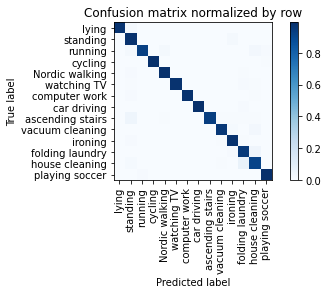

Overall accuracy: 0.965

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.998      0.981      0.990      0.139        579|	 standing: 0.009,	house cleaning: 0.005,	
         ironing       0.960      0.976      0.968      0.101        419|	 standing: 0.010,	folding laundry: 0.007,	
  house cleaning       0.924      0.911      0.918      0.097        403|	 folding laundry: 0.067,	standing: 0.012,	
           lying       1.000      0.973      0.986      0.089        372|	 standing: 0.019,	playing soccer: 0.003,	
        standing       0.903      0.981      0.941      0.089        371|	 ironing: 0.016,	computer work: 0.003,	
  Nordic walking       0.983      0.983      0.983      0.086        359|	 standing: 0.008,	folding laundry: 0.006,	
 vacuum cleaning       0.982      0.959      0.971      0.083        344|	 house cleaning: 0.023,	ironing: 0.015,	
         cycling       1.000      0.984      0.992      0.076        31

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

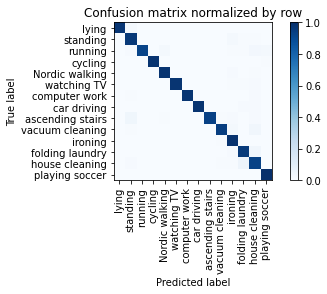

Overall accuracy: 0.965

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.998      0.979      0.989      0.139        578|	 house cleaning: 0.009,	standing: 0.007,	
         ironing       0.937      0.986      0.961      0.101        421|	 vacuum cleaning: 0.007,	house cleaning: 0.002,	
  house cleaning       0.903      0.928      0.915      0.097        402|	 folding laundry: 0.050,	standing: 0.010,	
           lying       1.000      0.973      0.986      0.090        373|	 standing: 0.019,	playing soccer: 0.003,	
        standing       0.927      0.965      0.945      0.088        367|	 ironing: 0.022,	house cleaning: 0.005,	
  Nordic walking       0.983      0.983      0.983      0.087        360|	 ironing: 0.008,	house cleaning: 0.006,	
 vacuum cleaning       0.979      0.945      0.962      0.083        345|	 house cleaning: 0.032,	ironing: 0.017,	
         cycling       1.000      0.984      0.992      0.075     

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

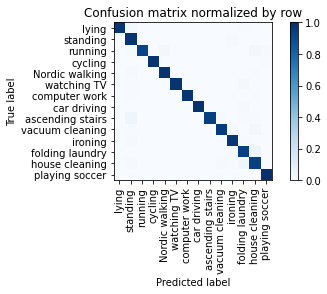

Overall accuracy: 0.967

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.998      0.981      0.990      0.139        580|	 house cleaning: 0.007,	standing: 0.007,	
         ironing       0.965      0.976      0.970      0.101        420|	 standing: 0.010,	folding laundry: 0.007,	
  house cleaning       0.911      0.938      0.925      0.097        405|	 folding laundry: 0.037,	vacuum cleaning: 0.010,	
           lying       1.000      0.973      0.986      0.089        371|	 standing: 0.019,	folding laundry: 0.005,	
        standing       0.905      0.981      0.941      0.088        368|	 ironing: 0.014,	house cleaning: 0.003,	
  Nordic walking       0.983      0.981      0.982      0.086        359|	 standing: 0.011,	house cleaning: 0.006,	
 vacuum cleaning       0.973      0.956      0.964      0.082        341|	 house cleaning: 0.026,	ironing: 0.012,	
         cycling       1.000      0.987      0.994      0.076  

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

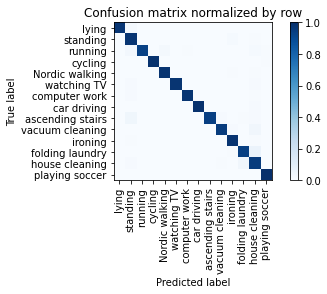

Overall accuracy: 0.969

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.996      0.979      0.988      0.140        581|	 standing: 0.009,	house cleaning: 0.007,	
         ironing       0.963      0.981      0.972      0.101        419|	 house cleaning: 0.007,	standing: 0.007,	
  house cleaning       0.895      0.950      0.922      0.097        403|	 folding laundry: 0.032,	standing: 0.010,	
           lying       1.000      0.973      0.986      0.089        370|	 standing: 0.019,	playing soccer: 0.003,	
        standing       0.909      0.978      0.942      0.088        367|	 ironing: 0.014,	house cleaning: 0.005,	
  Nordic walking       0.989      0.983      0.986      0.087        361|	 house cleaning: 0.006,	ironing: 0.006,	
 vacuum cleaning       0.985      0.950      0.967      0.082        343|	 house cleaning: 0.035,	ironing: 0.012,	
         cycling       1.000      0.987      0.994      0.075        313|

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

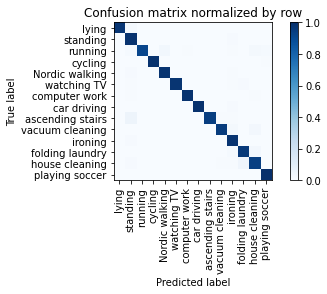

Overall accuracy: 0.970

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.996      0.984      0.990      0.139        578|	 house cleaning: 0.007,	standing: 0.005,	
         ironing       0.947      0.983      0.965      0.101        422|	 standing: 0.009,	house cleaning: 0.002,	
  house cleaning       0.938      0.938      0.938      0.097        405|	 folding laundry: 0.040,	standing: 0.010,	
        standing       0.910      0.986      0.947      0.089        370|	 ironing: 0.011,	computer work: 0.003,	
           lying       1.000      0.976      0.988      0.089        369|	 standing: 0.016,	playing soccer: 0.003,	
  Nordic walking       0.983      0.983      0.983      0.087        361|	 standing: 0.011,	ironing: 0.006,	
 vacuum cleaning       0.985      0.953      0.969      0.082        340|	 house cleaning: 0.026,	ironing: 0.018,	
         cycling       1.000      0.987      0.994      0.076        316|	 playi

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

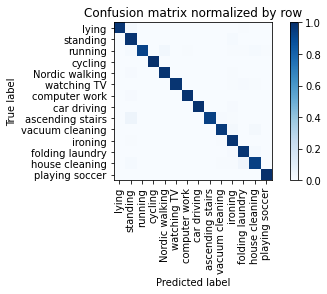

Overall accuracy: 0.972

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.997      0.988      0.992      0.139        579|	 standing: 0.009,	house cleaning: 0.002,	
         ironing       0.947      0.983      0.965      0.101        421|	 standing: 0.007,	vacuum cleaning: 0.005,	
  house cleaning       0.950      0.936      0.943      0.097        404|	 folding laundry: 0.040,	standing: 0.012,	
        standing       0.910      0.981      0.944      0.089        372|	 ironing: 0.013,	house cleaning: 0.003,	
           lying       1.000      0.976      0.988      0.089        370|	 standing: 0.016,	folding laundry: 0.005,	
  Nordic walking       0.983      0.983      0.983      0.087        360|	 standing: 0.008,	ironing: 0.006,	
 vacuum cleaning       0.979      0.959      0.969      0.082        343|	 house cleaning: 0.020,	ironing: 0.017,	
         cycling       1.000      0.994      0.997      0.076        315|	 ho

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

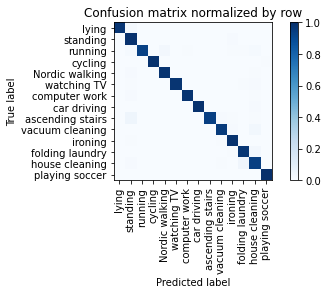

Overall accuracy: 0.972

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.998      0.981      0.989      0.138        575|	 standing: 0.009,	house cleaning: 0.005,	
         ironing       0.963      0.988      0.975      0.101        419|	 vacuum cleaning: 0.007,	standing: 0.005,	
  house cleaning       0.929      0.941      0.935      0.097        405|	 folding laundry: 0.042,	standing: 0.010,	
        standing       0.915      0.989      0.951      0.089        371|	 ironing: 0.011,	playing soccer: 0.000,	
           lying       1.000      0.976      0.988      0.089        369|	 standing: 0.016,	playing soccer: 0.003,	
  Nordic walking       0.986      0.983      0.985      0.086        358|	 standing: 0.008,	house cleaning: 0.006,	
 vacuum cleaning       0.979      0.956      0.968      0.082        343|	 house cleaning: 0.029,	ironing: 0.012,	
         cycling       1.000      0.987      0.994      0.076        31

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

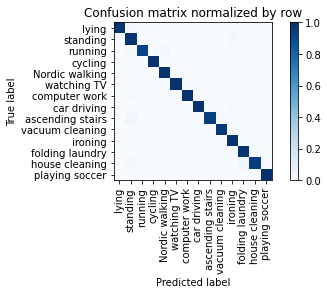

Overall accuracy: 0.974

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.997      0.986      0.991      0.140        582|	 standing: 0.009,	ironing: 0.003,	
         ironing       0.945      0.988      0.966      0.101        420|	 standing: 0.007,	house cleaning: 0.002,	
  house cleaning       0.960      0.948      0.954      0.097        404|	 folding laundry: 0.032,	standing: 0.010,	
        standing       0.919      0.978      0.948      0.089        371|	 ironing: 0.019,	computer work: 0.003,	
           lying       1.000      0.976      0.988      0.089        370|	 standing: 0.014,	folding laundry: 0.005,	
  Nordic walking       0.983      0.983      0.983      0.086        357|	 house cleaning: 0.006,	ironing: 0.006,	
 vacuum cleaning       0.976      0.965      0.971      0.082        343|	 ironing: 0.017,	house cleaning: 0.015,	
         cycling       1.000      0.987      0.994      0.075        314|	 playi

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

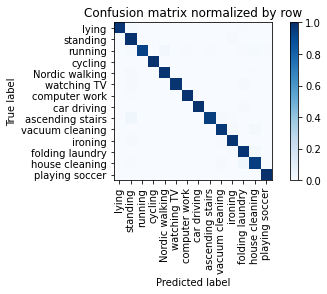

Overall accuracy: 0.974

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

   computer work       0.995      0.988      0.991      0.138        573|	 standing: 0.005,	house cleaning: 0.003,	
         ironing       0.972      0.983      0.978      0.101        422|	 standing: 0.009,	vacuum cleaning: 0.005,	
  house cleaning       0.953      0.943      0.948      0.098        406|	 folding laundry: 0.037,	vacuum cleaning: 0.010,	
        standing       0.918      0.989      0.952      0.089        372|	 ironing: 0.008,	computer work: 0.003,	
           lying       1.000      0.975      0.988      0.088        367|	 standing: 0.014,	folding laundry: 0.005,	
  Nordic walking       0.983      0.983      0.983      0.087        362|	 standing: 0.011,	house cleaning: 0.006,	
 vacuum cleaning       0.977      0.968      0.972      0.083        344|	 house cleaning: 0.017,	ironing: 0.012,	
         cycling       1.000      0.987      0.994      0.076   

unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

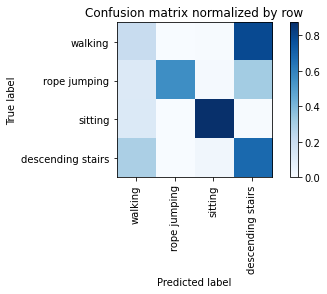

Overall accuracy: 0.534

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.467      0.207      0.287      0.421       2317|	 descending stairs: 0.788,	sitting: 0.005,	
          sitting       0.973      0.874      0.921      0.325       1790|	 walking: 0.122,	descending stairs: 0.004,	
descending stairs       0.245      0.681      0.361      0.171        941|	 walking: 0.291,	sitting: 0.028,	
     rope jumping       1.000      0.557      0.715      0.083        456|	 descending stairs: 0.311,	walking: 0.118,	

----------------------------------------------------------------------------------------------------
      avg / total       0.638      0.534      0.541        1.0       5504|	      

{'accuracy': 0.5339752906976745, 'precision': 0.6712854548621168, 'recall': 0.5797788051394892, 'f1': 0.57090830694426}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'compu

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

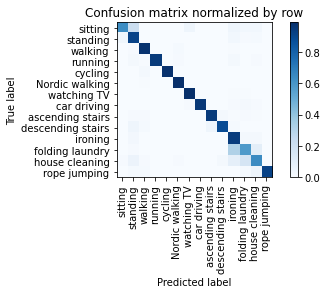

Overall accuracy: 0.871

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.758      0.940      0.839      0.118        453|	 standing: 0.024,	house cleaning: 0.018,	
          walking       0.957      0.973      0.965      0.114        438|	 Nordic walking: 0.014,	standing: 0.009,	
   house cleaning       0.826      0.642      0.722      0.100        385|	 folding laundry: 0.166,	ironing: 0.086,	
         standing       0.722      0.912      0.806      0.097        374|	 sitting: 0.035,	ironing: 0.029,	
   Nordic walking       0.970      0.983      0.976      0.093        358|	 walking: 0.006,	house cleaning: 0.003,	
          sitting       0.932      0.636      0.756      0.089        343|	 standing: 0.219,	ironing: 0.044,	
          cycling       0.997      0.979      0.988      0.085        326|	 walking: 0.018,	standing: 0.003,	
 ascending stairs       0.954      0.941      0.948      0.058        222|	 descending

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

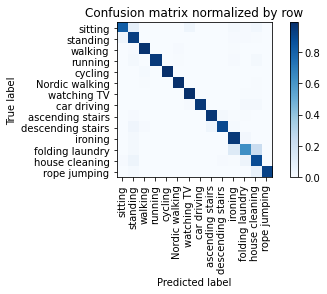

Overall accuracy: 0.919

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.902      0.952      0.926      0.119        456|	 folding laundry: 0.026,	standing: 0.020,	
          walking       0.982      0.975      0.978      0.114        437|	 Nordic walking: 0.009,	standing: 0.009,	
   house cleaning       0.818      0.880      0.848      0.100        384|	 folding laundry: 0.049,	standing: 0.047,	
         standing       0.814      0.932      0.869      0.096        370|	 sitting: 0.043,	folding laundry: 0.011,	
   Nordic walking       0.986      0.983      0.984      0.092        353|	 house cleaning: 0.006,	walking: 0.006,	
          sitting       0.937      0.811      0.869      0.091        349|	 standing: 0.086,	watching TV: 0.043,	
          cycling       0.997      0.985      0.991      0.084        324|	 walking: 0.012,	descending stairs: 0.003,	
 ascending stairs       0.959      0.959      0.959      0.058 

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

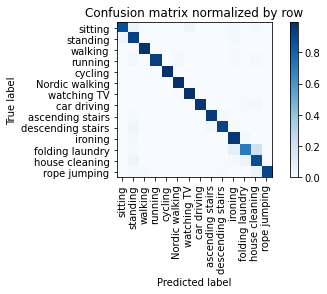

Overall accuracy: 0.930

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.912      0.961      0.936      0.120        461|	 standing: 0.022,	folding laundry: 0.017,	
          walking       0.986      0.982      0.984      0.114        436|	 standing: 0.007,	ironing: 0.005,	
   house cleaning       0.846      0.879      0.862      0.099        381|	 folding laundry: 0.058,	standing: 0.042,	
         standing       0.835      0.921      0.876      0.096        368|	 sitting: 0.049,	ironing: 0.019,	
   Nordic walking       0.986      0.983      0.985      0.093        358|	 house cleaning: 0.006,	walking: 0.006,	
          sitting       0.938      0.867      0.901      0.090        346|	 standing: 0.058,	watching TV: 0.043,	
          cycling       0.997      0.991      0.994      0.085        325|	 walking: 0.006,	standing: 0.003,	
 ascending stairs       0.977      0.959      0.968      0.057        220|	 descending 

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

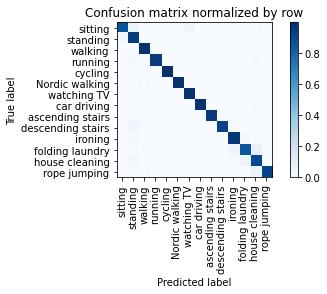

Overall accuracy: 0.946

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.938      0.967      0.952      0.119        456|	 standing: 0.018,	folding laundry: 0.013,	
          walking       0.982      0.982      0.982      0.113        435|	 standing: 0.007,	ironing: 0.005,	
   house cleaning       0.908      0.901      0.905      0.100        384|	 folding laundry: 0.047,	standing: 0.034,	
         standing       0.846      0.946      0.893      0.097        372|	 sitting: 0.038,	ironing: 0.008,	
   Nordic walking       0.991      0.983      0.987      0.092        352|	 walking: 0.009,	house cleaning: 0.003,	
          sitting       0.950      0.868      0.907      0.091        348|	 standing: 0.060,	watching TV: 0.043,	
          cycling       0.994      0.997      0.995      0.085        326|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.986      0.964      0.975      0.058        221|	 descend

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

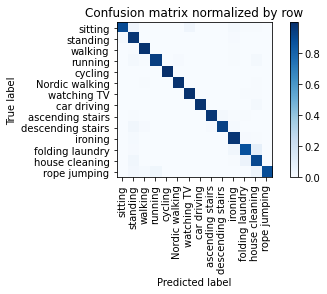

Overall accuracy: 0.952

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.942      0.973      0.957      0.117        451|	 standing: 0.013,	folding laundry: 0.009,	
          walking       0.986      0.984      0.985      0.114        436|	 standing: 0.007,	ironing: 0.005,	
   house cleaning       0.910      0.901      0.905      0.099        382|	 folding laundry: 0.055,	standing: 0.031,	
         standing       0.876      0.970      0.921      0.097        372|	 sitting: 0.019,	ironing: 0.011,	
   Nordic walking       0.992      0.983      0.987      0.093        357|	 house cleaning: 0.006,	walking: 0.006,	
          sitting       0.975      0.890      0.931      0.090        347|	 watching TV: 0.040,	standing: 0.040,	
          cycling       0.997      0.997      0.997      0.085        326|	 descending stairs: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.991      0.968      0.979      0.058        222

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

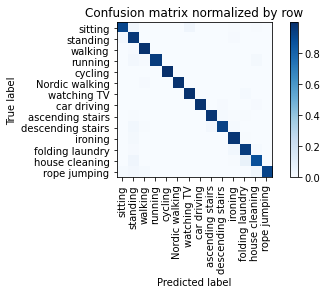

Overall accuracy: 0.956

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.957      0.971      0.964      0.118        453|	 standing: 0.020,	folding laundry: 0.007,	
          walking       0.982      0.986      0.984      0.114        436|	 standing: 0.009,	ironing: 0.002,	
   house cleaning       0.960      0.880      0.918      0.100        383|	 folding laundry: 0.068,	standing: 0.039,	
         standing       0.866      0.963      0.912      0.098        375|	 sitting: 0.027,	ironing: 0.011,	
   Nordic walking       0.997      0.983      0.990      0.093        357|	 walking: 0.008,	house cleaning: 0.003,	
          sitting       0.963      0.910      0.936      0.089        343|	 watching TV: 0.041,	standing: 0.032,	
          cycling       0.997      0.997      0.997      0.084        323|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.973      0.973      0.973      0.058        223|	 descend

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

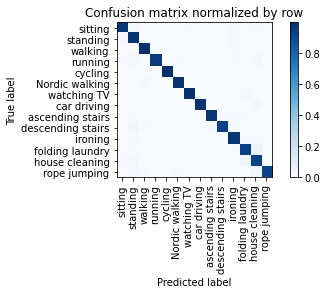

Overall accuracy: 0.965

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.963      0.971      0.967      0.118        455|	 standing: 0.018,	folding laundry: 0.007,	
          walking       0.984      0.986      0.985      0.114        439|	 standing: 0.007,	ironing: 0.005,	
   house cleaning       0.934      0.921      0.927      0.099        381|	 folding laundry: 0.039,	standing: 0.029,	
         standing       0.894      0.978      0.934      0.096        370|	 ironing: 0.011,	sitting: 0.011,	
   Nordic walking       0.992      0.983      0.987      0.093        357|	 walking: 0.008,	house cleaning: 0.003,	
          sitting       0.979      0.960      0.969      0.090        347|	 standing: 0.020,	ironing: 0.009,	
          cycling       1.000      0.997      0.998      0.085        325|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.982      0.973      0.977      0.058        222|	 descending 

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

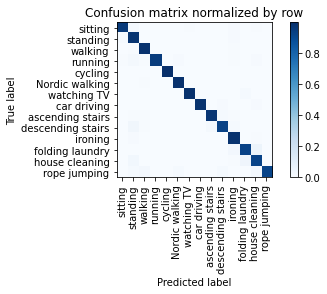

Overall accuracy: 0.966

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.953      0.985      0.969      0.119        458|	 standing: 0.009,	house cleaning: 0.004,	
          walking       0.982      0.986      0.984      0.113        432|	 standing: 0.007,	ironing: 0.005,	
   house cleaning       0.944      0.922      0.933      0.100        385|	 folding laundry: 0.039,	standing: 0.029,	
         standing       0.910      0.976      0.942      0.097        372|	 sitting: 0.013,	ironing: 0.011,	
   Nordic walking       0.989      0.986      0.987      0.092        355|	 walking: 0.006,	house cleaning: 0.003,	
          sitting       0.979      0.957      0.968      0.090        346|	 standing: 0.017,	ironing: 0.009,	
          cycling       1.000      0.997      0.998      0.084        322|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.977      0.973      0.975      0.058        223|	 descending s

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

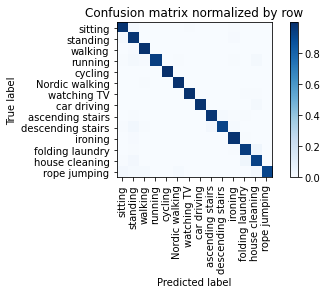

Overall accuracy: 0.968

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.970      0.980      0.975      0.119        458|	 standing: 0.011,	folding laundry: 0.007,	
          walking       0.984      0.988      0.986      0.113        433|	 standing: 0.009,	ironing: 0.002,	
   house cleaning       0.950      0.927      0.938      0.101        386|	 folding laundry: 0.036,	standing: 0.026,	
         standing       0.907      0.973      0.939      0.097        371|	 sitting: 0.019,	ironing: 0.008,	
   Nordic walking       0.994      0.986      0.990      0.093        356|	 walking: 0.006,	house cleaning: 0.003,	
          sitting       0.963      0.974      0.968      0.090        344|	 standing: 0.015,	ironing: 0.006,	
          cycling       1.000      0.997      0.998      0.085        326|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.977      0.973      0.975      0.057        220|	 descending 

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

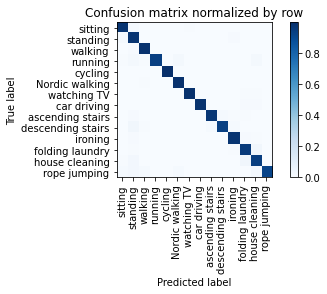

Overall accuracy: 0.970

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.976      0.976      0.976      0.118        453|	 folding laundry: 0.009,	standing: 0.009,	
          walking       0.986      0.986      0.986      0.113        434|	 standing: 0.012,	ironing: 0.002,	
   house cleaning       0.952      0.940      0.946      0.099        382|	 folding laundry: 0.031,	standing: 0.024,	
         standing       0.902      0.976      0.938      0.096        370|	 sitting: 0.016,	ironing: 0.008,	
   Nordic walking       0.989      0.986      0.987      0.093        357|	 walking: 0.006,	house cleaning: 0.003,	
          sitting       0.971      0.977      0.974      0.090        346|	 standing: 0.014,	watching TV: 0.006,	
          cycling       1.000      0.997      0.998      0.085        326|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.986      0.968      0.977      0.058        221|	 descend

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

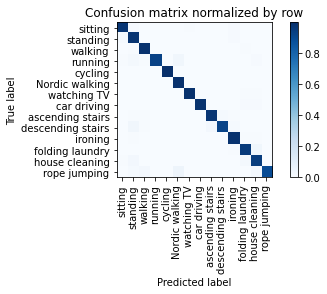

Overall accuracy: 0.970

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.970      0.983      0.976      0.120        460|	 folding laundry: 0.007,	standing: 0.007,	
          walking       0.984      0.986      0.985      0.114        436|	 folding laundry: 0.005,	standing: 0.005,	
   house cleaning       0.955      0.945      0.950      0.099        382|	 standing: 0.026,	folding laundry: 0.021,	
         standing       0.919      0.976      0.946      0.097        371|	 sitting: 0.013,	ironing: 0.011,	
   Nordic walking       0.969      0.989      0.979      0.092        353|	 house cleaning: 0.003,	folding laundry: 0.003,	
          sitting       0.977      0.971      0.974      0.090        346|	 standing: 0.012,	ironing: 0.009,	
          cycling       1.000      0.997      0.998      0.084        321|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.973      0.973      0.973      0.058        2

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

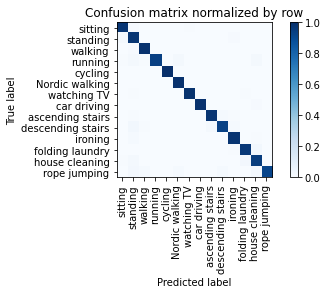

Overall accuracy: 0.973

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.976      0.978      0.977      0.119        457|	 standing: 0.015,	house cleaning: 0.004,	
          walking       0.991      0.989      0.990      0.114        437|	 standing: 0.009,	ironing: 0.002,	
   house cleaning       0.958      0.948      0.953      0.100        384|	 folding laundry: 0.026,	standing: 0.021,	
         standing       0.908      0.976      0.941      0.097        373|	 sitting: 0.016,	ironing: 0.008,	
   Nordic walking       0.989      0.989      0.989      0.092        355|	 house cleaning: 0.003,	folding laundry: 0.003,	
          sitting       0.974      0.974      0.974      0.090        345|	 standing: 0.012,	watching TV: 0.006,	
          cycling       1.000      1.000      1.000      0.085        326|	 rope jumping: 0.000,	house cleaning: 0.000,	
 ascending stairs       0.977      0.977      0.977      0.058       

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

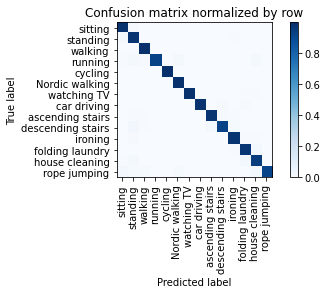

Overall accuracy: 0.973

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.978      0.980      0.979      0.118        455|	 standing: 0.009,	folding laundry: 0.007,	
          walking       0.984      0.991      0.987      0.113        435|	 standing: 0.005,	folding laundry: 0.002,	
   house cleaning       0.963      0.948      0.955      0.100        384|	 folding laundry: 0.029,	standing: 0.018,	
         standing       0.924      0.976      0.949      0.097        373|	 sitting: 0.016,	ironing: 0.005,	
   Nordic walking       0.989      0.989      0.989      0.093        356|	 house cleaning: 0.003,	folding laundry: 0.003,	
          sitting       0.968      0.983      0.975      0.089        343|	 standing: 0.012,	ironing: 0.003,	
          cycling       1.000      0.997      0.998      0.085        326|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.982      0.977      0.980      0.058        2

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

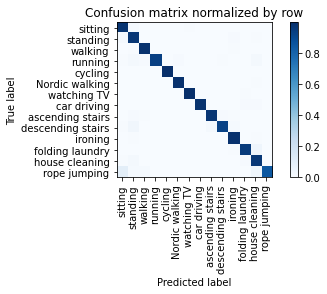

Overall accuracy: 0.971

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.974      0.987      0.980      0.119        457|	 house cleaning: 0.007,	standing: 0.007,	
          walking       0.986      0.989      0.987      0.114        436|	 standing: 0.007,	ironing: 0.005,	
   house cleaning       0.939      0.964      0.951      0.100        385|	 standing: 0.021,	folding laundry: 0.010,	
         standing       0.915      0.967      0.941      0.096        368|	 sitting: 0.019,	ironing: 0.008,	
   Nordic walking       0.994      0.986      0.990      0.093        356|	 house cleaning: 0.006,	ironing: 0.003,	
          sitting       0.947      0.977      0.962      0.090        347|	 standing: 0.014,	watching TV: 0.006,	
          cycling       1.000      0.997      0.998      0.084        324|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.982      0.973      0.977      0.058        222|	 descendi

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

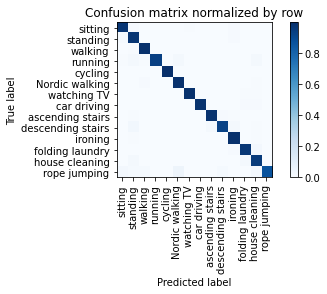

Overall accuracy: 0.972

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          ironing       0.968      0.991      0.979      0.118        454|	 house cleaning: 0.004,	standing: 0.004,	
          walking       0.986      0.991      0.989      0.114        436|	 standing: 0.007,	ironing: 0.002,	
   house cleaning       0.953      0.953      0.953      0.101        386|	 folding laundry: 0.023,	standing: 0.021,	
         standing       0.926      0.973      0.949      0.097        372|	 sitting: 0.013,	ironing: 0.011,	
   Nordic walking       0.978      0.986      0.982      0.092        354|	 walking: 0.008,	house cleaning: 0.006,	
          sitting       0.974      0.971      0.972      0.090        345|	 standing: 0.012,	ironing: 0.009,	
          cycling       1.000      0.997      0.998      0.085        327|	 walking: 0.003,	rope jumping: 0.000,	
 ascending stairs       0.982      0.982      0.982      0.058        222|	 descending s

unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

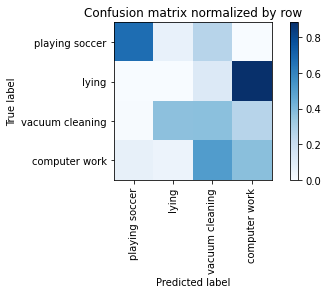

Overall accuracy: 0.294

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.353      0.372      0.362      0.432       3066|	 vacuum cleaning: 0.508,	playing soccer: 0.069,	
          lying       0.004      0.002      0.002      0.264       1872|	 computer work: 0.881,	vacuum cleaning: 0.118,	
vacuum cleaning       0.251      0.371      0.299      0.240       1708|	 lying: 0.366,	computer work: 0.259,	
 playing soccer       0.586      0.672      0.626      0.064        458|	 vacuum cleaning: 0.260,	lying: 0.068,	

----------------------------------------------------------------------------------------------------
    avg / total       0.251      0.294      0.269 0.9999999999999999       7104|	      

{'accuracy': 0.29363738738738737, 'precision': 0.29821068906232806, 'recall': 0.3543580362961396, 'f1': 0.3224491200520864}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
see

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

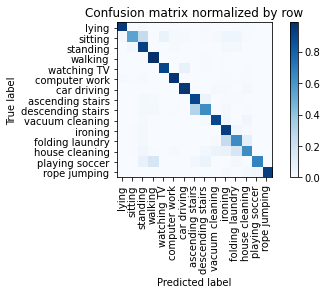

Overall accuracy: 0.850

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.970      0.963      0.967      0.139        615|	 standing: 0.008,	lying: 0.008,	
          walking       0.950      0.986      0.968      0.110        485|	 ironing: 0.006,	descending stairs: 0.004,	
          ironing       0.782      0.931      0.850      0.101        447|	 folding laundry: 0.038,	standing: 0.016,	
            lying       0.967      0.950      0.958      0.091        401|	 standing: 0.012,	descending stairs: 0.010,	
   house cleaning       0.845      0.632      0.723      0.086        380|	 folding laundry: 0.161,	ironing: 0.066,	
         standing       0.708      0.925      0.802      0.085        374|	 sitting: 0.024,	folding laundry: 0.019,	
          sitting       0.922      0.542      0.683      0.084        369|	 standing: 0.241,	watching TV: 0.062,	
  vacuum cleaning       0.909      0.895      0.902      0.078       

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

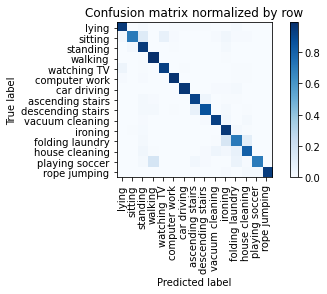

Overall accuracy: 0.902

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.985      0.971      0.978      0.139        615|	 standing: 0.008,	lying: 0.008,	
          walking       0.952      0.990      0.970      0.109        482|	 standing: 0.006,	ironing: 0.004,	
          ironing       0.848      0.955      0.898      0.102        449|	 folding laundry: 0.020,	standing: 0.013,	
            lying       0.946      0.950      0.948      0.091        402|	 folding laundry: 0.015,	standing: 0.012,	
   house cleaning       0.890      0.810      0.848      0.086        379|	 folding laundry: 0.071,	vacuum cleaning: 0.045,	
         standing       0.788      0.944      0.859      0.085        375|	 sitting: 0.027,	ironing: 0.021,	
          sitting       0.949      0.707      0.810      0.083        368|	 standing: 0.122,	watching TV: 0.076,	
  vacuum cleaning       0.930      0.928      0.929      0.078        345|	 iron

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

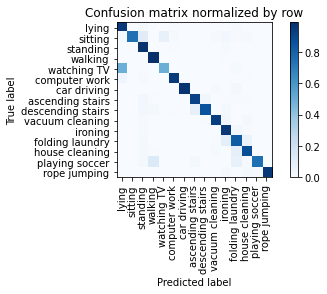

Overall accuracy: 0.900

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.985      0.941      0.963      0.139        614|	 lying: 0.042,	standing: 0.008,	
          walking       0.962      0.988      0.975      0.110        484|	 ironing: 0.004,	standing: 0.004,	
          ironing       0.897      0.953      0.924      0.102        449|	 folding laundry: 0.027,	standing: 0.013,	
            lying       0.775      0.955      0.856      0.091        401|	 standing: 0.017,	folding laundry: 0.012,	
   house cleaning       0.915      0.874      0.894      0.086        381|	 folding laundry: 0.087,	standing: 0.018,	
         standing       0.808      0.976      0.884      0.085        374|	 ironing: 0.013,	computer work: 0.005,	
          sitting       0.989      0.741      0.847      0.083        367|	 standing: 0.109,	watching TV: 0.074,	
  vacuum cleaning       0.970      0.934      0.951      0.078        346|	 ironi

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

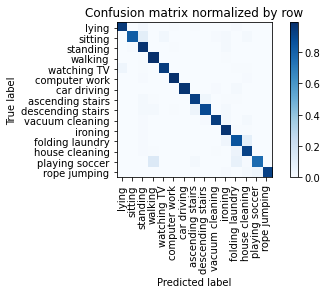

Overall accuracy: 0.937

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.982      0.987      0.139        616|	 house cleaning: 0.008,	standing: 0.008,	
          walking       0.960      0.990      0.975      0.110        484|	 ironing: 0.004,	standing: 0.004,	
          ironing       0.921      0.973      0.947      0.101        446|	 standing: 0.011,	folding laundry: 0.007,	
            lying       0.982      0.947      0.964      0.090        399|	 standing: 0.025,	folding laundry: 0.010,	
   house cleaning       0.895      0.916      0.906      0.087        382|	 folding laundry: 0.058,	standing: 0.010,	
         standing       0.827      0.971      0.893      0.085        375|	 ironing: 0.016,	sitting: 0.008,	
          sitting       0.984      0.823      0.896      0.083        368|	 standing: 0.098,	watching TV: 0.027,	
  vacuum cleaning       0.979      0.939      0.959      0.078        346|	 ho

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

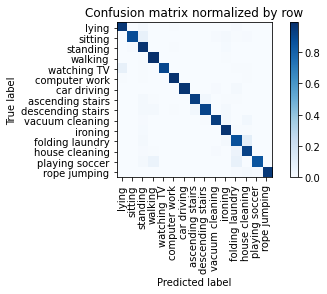

Overall accuracy: 0.944

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.977      0.984      0.139        615|	 house cleaning: 0.007,	standing: 0.007,	
          walking       0.976      0.990      0.983      0.110        484|	 standing: 0.006,	ironing: 0.004,	
          ironing       0.940      0.973      0.956      0.102        450|	 standing: 0.013,	folding laundry: 0.007,	
            lying       0.960      0.958      0.959      0.091        400|	 standing: 0.022,	folding laundry: 0.010,	
   house cleaning       0.895      0.919      0.907      0.086        381|	 folding laundry: 0.055,	standing: 0.010,	
         standing       0.836      0.973      0.900      0.084        373|	 ironing: 0.013,	sitting: 0.008,	
          sitting       0.988      0.878      0.929      0.083        368|	 standing: 0.076,	ironing: 0.016,	
  vacuum cleaning       0.976      0.936      0.956      0.078        345|	 house 

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

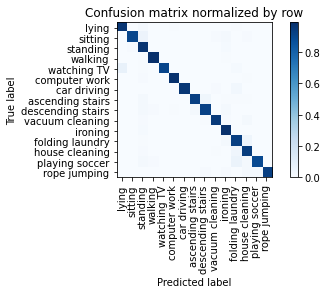

Overall accuracy: 0.954

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.980      0.987      0.139        613|	 standing: 0.010,	house cleaning: 0.005,	
          walking       0.992      0.990      0.991      0.109        483|	 standing: 0.006,	ironing: 0.004,	
          ironing       0.940      0.982      0.961      0.101        447|	 standing: 0.013,	house cleaning: 0.002,	
            lying       0.965      0.965      0.965      0.091        403|	 standing: 0.022,	folding laundry: 0.005,	
   house cleaning       0.922      0.937      0.929      0.086        379|	 folding laundry: 0.042,	standing: 0.008,	
         standing       0.853      0.973      0.909      0.085        375|	 ironing: 0.013,	sitting: 0.011,	
          sitting       0.985      0.902      0.942      0.083        368|	 standing: 0.057,	ironing: 0.019,	
  vacuum cleaning       0.982      0.951      0.966      0.078        346|	 house c

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

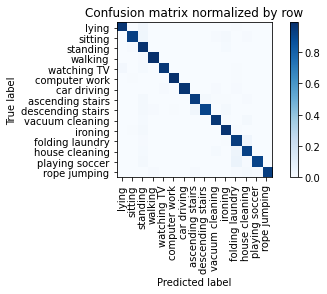

Overall accuracy: 0.958

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.998      0.984      0.991      0.139        615|	 sitting: 0.007,	folding laundry: 0.005,	
          walking       0.992      0.990      0.991      0.110        484|	 standing: 0.008,	ironing: 0.002,	
          ironing       0.956      0.973      0.965      0.101        448|	 standing: 0.016,	folding laundry: 0.004,	
            lying       0.990      0.963      0.976      0.091        402|	 standing: 0.032,	folding laundry: 0.005,	
   house cleaning       0.939      0.921      0.930      0.086        381|	 folding laundry: 0.047,	vacuum cleaning: 0.013,	
         standing       0.854      0.976      0.911      0.084        372|	 ironing: 0.013,	sitting: 0.011,	
          sitting       0.969      0.927      0.947      0.083        368|	 standing: 0.035,	ironing: 0.016,	
  vacuum cleaning       0.971      0.959      0.965      0.078        344|	

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

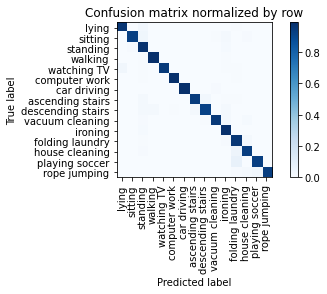

Overall accuracy: 0.962

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.998      0.984      0.991      0.139        616|	 folding laundry: 0.005,	standing: 0.005,	
          walking       0.992      0.990      0.991      0.110        485|	 standing: 0.006,	ironing: 0.004,	
          ironing       0.940      0.984      0.962      0.101        446|	 standing: 0.013,	house cleaning: 0.002,	
            lying       0.985      0.965      0.975      0.091        403|	 standing: 0.027,	folding laundry: 0.005,	
   house cleaning       0.952      0.932      0.942      0.087        382|	 folding laundry: 0.050,	standing: 0.010,	
         standing       0.871      0.976      0.921      0.085        375|	 ironing: 0.013,	sitting: 0.011,	
          sitting       0.983      0.927      0.954      0.083        368|	 standing: 0.038,	ironing: 0.019,	
  vacuum cleaning       0.988      0.953      0.970      0.078        344|	 ironin

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

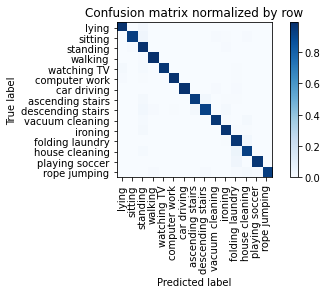

Overall accuracy: 0.962

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.998      0.977      0.988      0.139        614|	 lying: 0.008,	folding laundry: 0.005,	
          walking       0.992      0.990      0.991      0.110        485|	 standing: 0.008,	ironing: 0.002,	
          ironing       0.967      0.967      0.967      0.101        448|	 standing: 0.022,	folding laundry: 0.007,	
            lying       0.980      0.975      0.978      0.091        402|	 standing: 0.025,	rope jumping: 0.000,	
   house cleaning       0.944      0.927      0.935      0.087        382|	 folding laundry: 0.052,	standing: 0.013,	
         standing       0.855      0.979      0.913      0.085        374|	 ironing: 0.011,	sitting: 0.011,	
          sitting       0.983      0.932      0.957      0.084        369|	 standing: 0.041,	house cleaning: 0.011,	
  vacuum cleaning       0.985      0.959      0.972      0.078        344|	 hous

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

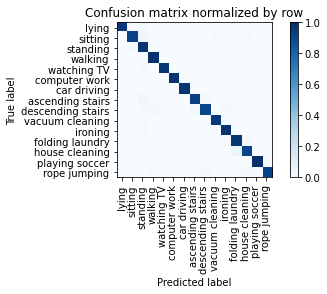

Overall accuracy: 0.964

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.998      0.982      0.990      0.140        617|	 standing: 0.005,	folding laundry: 0.003,	
          walking       0.988      0.990      0.989      0.109        483|	 standing: 0.008,	ironing: 0.002,	
          ironing       0.957      0.987      0.971      0.102        449|	 standing: 0.013,	rope jumping: 0.000,	
            lying       0.990      0.968      0.979      0.091        402|	 standing: 0.027,	folding laundry: 0.005,	
   house cleaning       0.961      0.916      0.938      0.086        381|	 folding laundry: 0.060,	standing: 0.010,	
         standing       0.865      0.981      0.920      0.084        373|	 ironing: 0.011,	sitting: 0.008,	
          sitting       0.983      0.932      0.957      0.084        369|	 standing: 0.035,	house cleaning: 0.011,	
  vacuum cleaning       0.979      0.959      0.969      0.078        345|	 i

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

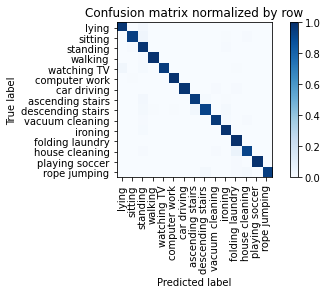

Overall accuracy: 0.967

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.997      0.985      0.991      0.139        612|	 sitting: 0.007,	house cleaning: 0.003,	
          walking       0.996      0.990      0.993      0.110        484|	 standing: 0.008,	ironing: 0.002,	
          ironing       0.963      0.984      0.974      0.102        450|	 standing: 0.013,	folding laundry: 0.002,	
            lying       0.987      0.970      0.979      0.091        402|	 standing: 0.025,	house cleaning: 0.002,	
   house cleaning       0.964      0.919      0.941      0.087        382|	 folding laundry: 0.060,	vacuum cleaning: 0.008,	
         standing       0.874      0.979      0.923      0.085        374|	 ironing: 0.011,	sitting: 0.008,	
          sitting       0.977      0.938      0.957      0.083        368|	 standing: 0.041,	house cleaning: 0.011,	
  vacuum cleaning       0.985      0.962      0.974      0.078        

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

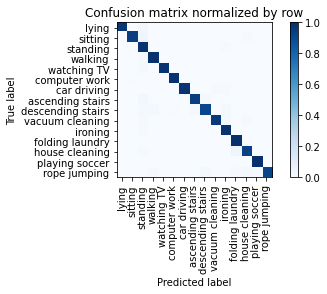

Overall accuracy: 0.969

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.997      0.985      0.991      0.140        617|	 sitting: 0.006,	lying: 0.003,	
          walking       0.988      0.990      0.989      0.109        482|	 standing: 0.008,	ironing: 0.002,	
          ironing       0.959      0.987      0.973      0.102        450|	 standing: 0.013,	rope jumping: 0.000,	
            lying       0.995      0.973      0.984      0.091        401|	 standing: 0.025,	computer work: 0.002,	
   house cleaning       0.970      0.932      0.950      0.086        380|	 folding laundry: 0.042,	standing: 0.013,	
         standing       0.867      0.984      0.922      0.084        372|	 ironing: 0.011,	sitting: 0.005,	
          sitting       0.980      0.943      0.961      0.083        367|	 standing: 0.041,	house cleaning: 0.011,	
  vacuum cleaning       0.991      0.959      0.975      0.078        344|	 ironing: 0.017

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

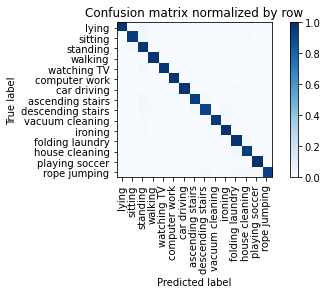

Overall accuracy: 0.971

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.998      0.985      0.992      0.139        614|	 sitting: 0.007,	house cleaning: 0.005,	
          walking       0.994      0.990      0.992      0.110        485|	 standing: 0.008,	ironing: 0.002,	
          ironing       0.969      0.989      0.979      0.101        448|	 standing: 0.009,	house cleaning: 0.002,	
            lying       0.997      0.973      0.985      0.091        402|	 standing: 0.025,	house cleaning: 0.002,	
   house cleaning       0.945      0.950      0.948      0.087        382|	 folding laundry: 0.034,	standing: 0.008,	
         standing       0.884      0.979      0.929      0.085        374|	 ironing: 0.011,	sitting: 0.008,	
          sitting       0.980      0.951      0.965      0.083        367|	 standing: 0.030,	house cleaning: 0.011,	
  vacuum cleaning       0.988      0.962      0.975      0.078        346|	 ho

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

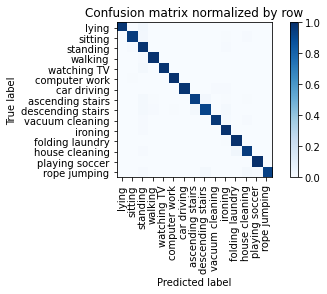

Overall accuracy: 0.973

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.998      0.989      0.993      0.139        615|	 sitting: 0.007,	house cleaning: 0.002,	
          walking       0.992      0.990      0.991      0.110        485|	 standing: 0.008,	ironing: 0.002,	
          ironing       0.957      0.991      0.974      0.102        449|	 standing: 0.009,	rope jumping: 0.000,	
            lying       1.000      0.970      0.985      0.091        402|	 standing: 0.027,	folding laundry: 0.002,	
   house cleaning       0.970      0.950      0.960      0.086        380|	 folding laundry: 0.034,	standing: 0.008,	
         standing       0.884      0.981      0.930      0.085        374|	 ironing: 0.011,	sitting: 0.008,	
          sitting       0.978      0.951      0.964      0.084        369|	 standing: 0.027,	house cleaning: 0.011,	
  vacuum cleaning       0.994      0.968      0.981      0.078        345|	 iro

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

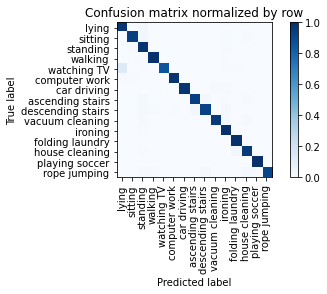

Overall accuracy: 0.967

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.998      0.977      0.988      0.139        614|	 lying: 0.010,	sitting: 0.005,	
          walking       0.992      0.990      0.991      0.109        481|	 standing: 0.006,	ironing: 0.004,	
          ironing       0.951      0.993      0.971      0.101        445|	 standing: 0.007,	rope jumping: 0.000,	
            lying       0.938      0.975      0.956      0.091        403|	 standing: 0.025,	rope jumping: 0.000,	
   house cleaning       0.956      0.963      0.959      0.086        381|	 folding laundry: 0.024,	standing: 0.005,	
         standing       0.897      0.979      0.936      0.085        374|	 ironing: 0.011,	sitting: 0.008,	
          sitting       0.980      0.943      0.961      0.084        370|	 standing: 0.027,	ironing: 0.014,	
  vacuum cleaning       0.994      0.962      0.978      0.078        346|	 house cleaning: 0.014,

unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

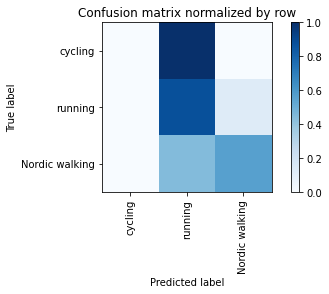

Overall accuracy: 0.426

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.900      0.562      0.692      0.419       1823|	 running: 0.438,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.365       1588|	 running: 1.000,	Nordic walking: 0.000,	
       running       0.257      0.879      0.398      0.216        941|	 Nordic walking: 0.121,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.433      0.426      0.376        1.0       4352|	      

{'accuracy': 0.4255514705882353, 'precision': 0.38576801643819497, 'recall': 0.48037076525810923, 'f1': 0.3634234568699921}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unseen classes >  [13, 9, 14]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

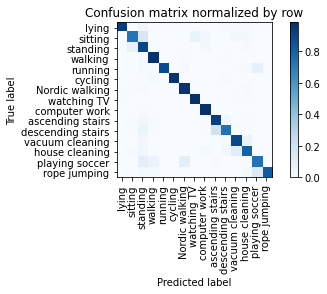

Overall accuracy: 0.900

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.957      0.985      0.971      0.132        590|	 standing: 0.007,	sitting: 0.003,	
          walking       0.967      0.975      0.971      0.109        488|	 standing: 0.012,	Nordic walking: 0.006,	
   house cleaning       0.879      0.796      0.835      0.087        392|	 vacuum cleaning: 0.105,	standing: 0.036,	
          sitting       0.885      0.730      0.800      0.083        370|	 standing: 0.149,	watching TV: 0.062,	
            lying       0.994      0.936      0.964      0.080        359|	 standing: 0.033,	house cleaning: 0.011,	
   Nordic walking       0.959      0.971      0.965      0.076        340|	 house cleaning: 0.009,	standing: 0.009,	
         standing       0.693      0.902      0.784      0.075        338|	 sitting: 0.071,	computer work: 0.018,	
  vacuum cleaning       0.840      0.896      0.867      0.071        316|

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

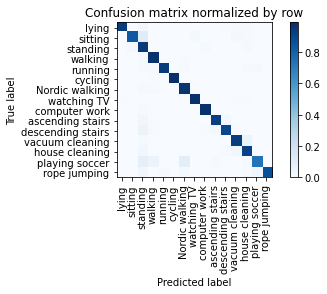

Overall accuracy: 0.942

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.990      0.990      0.132        590|	 standing: 0.008,	lying: 0.002,	
          walking       0.967      0.981      0.974      0.108        485|	 standing: 0.012,	Nordic walking: 0.006,	
   house cleaning       0.918      0.921      0.919      0.087        390|	 vacuum cleaning: 0.036,	standing: 0.026,	
          sitting       0.963      0.837      0.895      0.082        368|	 standing: 0.114,	vacuum cleaning: 0.019,	
            lying       0.994      0.942      0.967      0.080        359|	 standing: 0.036,	house cleaning: 0.008,	
   Nordic walking       0.954      0.971      0.962      0.077        343|	 standing: 0.012,	walking: 0.009,	
         standing       0.734      0.950      0.828      0.076        340|	 sitting: 0.029,	computer work: 0.012,	
          cycling       0.997      0.987      0.992      0.071        317|	 wal

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

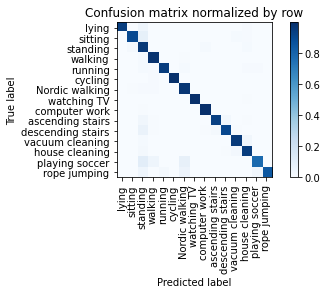

Overall accuracy: 0.951

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.993      0.992      0.131        588|	 standing: 0.007,	rope jumping: 0.000,	
          walking       0.970      0.982      0.976      0.109        489|	 standing: 0.014,	Nordic walking: 0.004,	
   house cleaning       0.932      0.941      0.936      0.087        391|	 vacuum cleaning: 0.026,	standing: 0.023,	
          sitting       0.976      0.895      0.934      0.083        371|	 standing: 0.084,	vacuum cleaning: 0.013,	
            lying       1.000      0.939      0.968      0.080        358|	 standing: 0.045,	house cleaning: 0.011,	
         standing       0.749      0.959      0.841      0.076        339|	 sitting: 0.018,	house cleaning: 0.012,	
   Nordic walking       0.951      0.970      0.960      0.075        338|	 walking: 0.009,	standing: 0.009,	
  vacuum cleaning       0.947      0.953      0.950      0.071        3

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

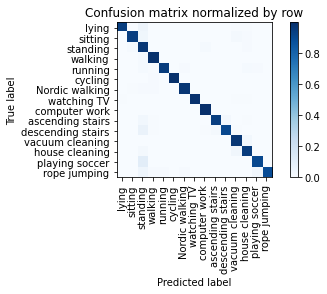

Overall accuracy: 0.961

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.995      0.993      0.131        589|	 standing: 0.003,	sitting: 0.002,	
          walking       0.980      0.988      0.984      0.109        488|	 standing: 0.012,	rope jumping: 0.000,	
   house cleaning       0.942      0.947      0.944      0.088        393|	 vacuum cleaning: 0.033,	standing: 0.018,	
          sitting       0.975      0.940      0.957      0.082        368|	 standing: 0.035,	vacuum cleaning: 0.016,	
            lying       0.997      0.939      0.967      0.080        360|	 standing: 0.047,	house cleaning: 0.006,	
   Nordic walking       0.991      0.971      0.981      0.077        343|	 walking: 0.009,	standing: 0.009,	
         standing       0.797      0.965      0.873      0.076        341|	 sitting: 0.015,	computer work: 0.012,	
  vacuum cleaning       0.930      0.965      0.947      0.071        317|	 hou

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

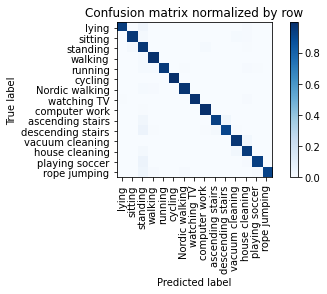

Overall accuracy: 0.965

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.993      0.992      0.132        590|	 standing: 0.005,	sitting: 0.002,	
          walking       0.982      0.988      0.985      0.108        486|	 standing: 0.012,	rope jumping: 0.000,	
   house cleaning       0.944      0.949      0.947      0.087        392|	 vacuum cleaning: 0.028,	standing: 0.020,	
          sitting       0.973      0.960      0.966      0.083        371|	 standing: 0.019,	vacuum cleaning: 0.013,	
            lying       0.997      0.942      0.969      0.080        360|	 standing: 0.042,	house cleaning: 0.008,	
   Nordic walking       0.994      0.974      0.984      0.077        343|	 standing: 0.012,	walking: 0.009,	
         standing       0.815      0.965      0.884      0.076        339|	 sitting: 0.018,	computer work: 0.012,	
  vacuum cleaning       0.944      0.968      0.956      0.071        316|	 hou

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

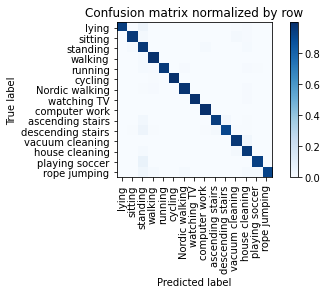

Overall accuracy: 0.966

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.991      0.995      0.993      0.130        584|	 standing: 0.003,	sitting: 0.002,	
          walking       0.982      0.988      0.985      0.108        486|	 standing: 0.012,	rope jumping: 0.000,	
   house cleaning       0.924      0.959      0.941      0.088        393|	 vacuum cleaning: 0.023,	standing: 0.015,	
          sitting       0.981      0.959      0.970      0.082        368|	 vacuum cleaning: 0.016,	standing: 0.016,	
            lying       1.000      0.937      0.967      0.081        364|	 standing: 0.049,	house cleaning: 0.008,	
   Nordic walking       0.991      0.977      0.984      0.077        344|	 house cleaning: 0.009,	walking: 0.009,	
         standing       0.829      0.962      0.890      0.076        342|	 house cleaning: 0.015,	computer work: 0.012,	
          cycling       0.997      0.991      0.994      0.071    

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

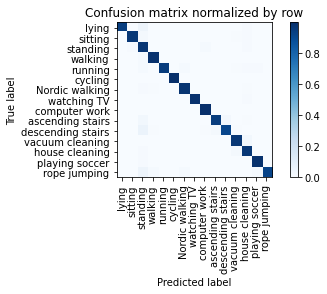

Overall accuracy: 0.969

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.995      0.993      0.131        589|	 sitting: 0.003,	standing: 0.002,	
          walking       0.992      0.988      0.990      0.109        488|	 standing: 0.012,	rope jumping: 0.000,	
   house cleaning       0.936      0.964      0.950      0.088        394|	 vacuum cleaning: 0.020,	standing: 0.010,	
          sitting       0.986      0.965      0.975      0.082        369|	 standing: 0.019,	house cleaning: 0.011,	
            lying       1.000      0.940      0.969      0.081        364|	 standing: 0.049,	house cleaning: 0.008,	
   Nordic walking       0.988      0.977      0.983      0.077        347|	 standing: 0.009,	house cleaning: 0.006,	
         standing       0.834      0.971      0.897      0.076        341|	 computer work: 0.012,	house cleaning: 0.009,	
  vacuum cleaning       0.963      0.969      0.966      0.071    

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

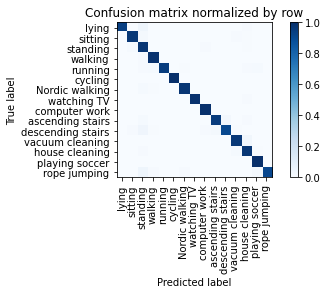

Overall accuracy: 0.971

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.995      0.992      0.132        590|	 sitting: 0.003,	standing: 0.002,	
          walking       0.986      0.990      0.988      0.109        487|	 standing: 0.010,	rope jumping: 0.000,	
   house cleaning       0.943      0.969      0.956      0.087        391|	 vacuum cleaning: 0.013,	standing: 0.010,	
          sitting       0.975      0.967      0.971      0.082        368|	 standing: 0.016,	vacuum cleaning: 0.011,	
            lying       1.000      0.940      0.969      0.081        364|	 standing: 0.047,	house cleaning: 0.008,	
   Nordic walking       0.994      0.977      0.985      0.076        341|	 standing: 0.012,	walking: 0.006,	
         standing       0.856      0.974      0.911      0.076        341|	 sitting: 0.012,	computer work: 0.009,	
  vacuum cleaning       0.969      0.966      0.967      0.071        319|	 hou

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

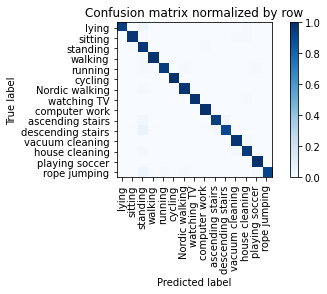

Overall accuracy: 0.972

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.995      0.994      0.131        588|	 sitting: 0.003,	standing: 0.002,	
          walking       0.990      0.990      0.990      0.110        491|	 standing: 0.010,	rope jumping: 0.000,	
   house cleaning       0.959      0.964      0.962      0.087        389|	 vacuum cleaning: 0.021,	standing: 0.013,	
          sitting       0.970      0.973      0.971      0.082        367|	 standing: 0.011,	house cleaning: 0.008,	
            lying       1.000      0.939      0.969      0.081        362|	 standing: 0.044,	house cleaning: 0.008,	
   Nordic walking       0.991      0.980      0.985      0.077        343|	 standing: 0.012,	walking: 0.006,	
         standing       0.853      0.974      0.909      0.076        340|	 sitting: 0.015,	computer work: 0.009,	
  vacuum cleaning       0.954      0.978      0.966      0.071        318|	 hous

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

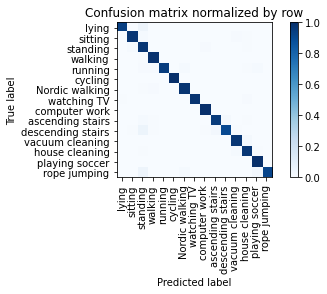

Overall accuracy: 0.973

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.992      0.997      0.994      0.131        586|	 standing: 0.002,	sitting: 0.002,	
          walking       0.984      0.992      0.988      0.110        492|	 standing: 0.006,	descending stairs: 0.002,	
   house cleaning       0.957      0.972      0.965      0.088        393|	 vacuum cleaning: 0.013,	standing: 0.008,	
          sitting       0.981      0.973      0.977      0.082        369|	 standing: 0.014,	vacuum cleaning: 0.008,	
            lying       0.997      0.941      0.968      0.079        356|	 standing: 0.048,	house cleaning: 0.003,	
   Nordic walking       0.988      0.980      0.984      0.077        343|	 walking: 0.009,	standing: 0.006,	
         standing       0.864      0.974      0.916      0.076        340|	 sitting: 0.012,	computer work: 0.009,	
          cycling       1.000      0.997      0.998      0.071        318|

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

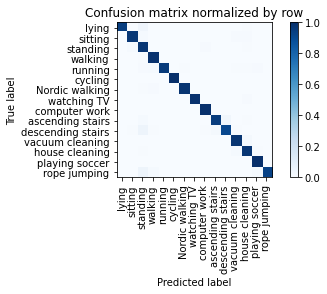

Overall accuracy: 0.973

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.995      0.994      0.131        586|	 sitting: 0.003,	standing: 0.002,	
          walking       0.984      0.992      0.988      0.109        489|	 standing: 0.006,	descending stairs: 0.002,	
   house cleaning       0.955      0.975      0.965      0.088        394|	 vacuum cleaning: 0.013,	standing: 0.008,	
          sitting       0.975      0.967      0.971      0.082        369|	 standing: 0.014,	vacuum cleaning: 0.011,	
            lying       1.000      0.944      0.971      0.080        360|	 standing: 0.042,	house cleaning: 0.006,	
   Nordic walking       0.997      0.980      0.988      0.076        342|	 walking: 0.009,	standing: 0.006,	
         standing       0.871      0.974      0.919      0.076        340|	 sitting: 0.012,	computer work: 0.009,	
  vacuum cleaning       0.963      0.978      0.970      0.071        316|

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

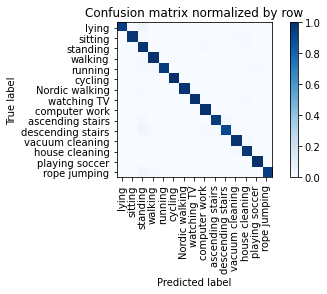

Overall accuracy: 0.974

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.997      0.993      0.131        589|	 standing: 0.002,	sitting: 0.002,	
          walking       0.988      0.990      0.989      0.110        491|	 standing: 0.008,	descending stairs: 0.002,	
   house cleaning       0.955      0.972      0.963      0.087        391|	 vacuum cleaning: 0.015,	standing: 0.008,	
          sitting       0.981      0.973      0.977      0.082        368|	 standing: 0.011,	house cleaning: 0.008,	
            lying       1.000      0.942      0.970      0.081        363|	 standing: 0.041,	house cleaning: 0.006,	
         standing       0.868      0.977      0.919      0.077        343|	 house cleaning: 0.009,	computer work: 0.009,	
   Nordic walking       1.000      0.982      0.991      0.076        342|	 standing: 0.012,	descending stairs: 0.003,	
  vacuum cleaning       0.966      0.978      0.972      0

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

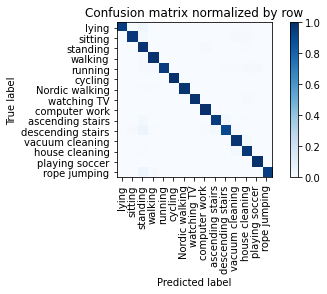

Overall accuracy: 0.974

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.993      0.995      0.994      0.131        588|	 sitting: 0.003,	standing: 0.002,	
          walking       0.988      0.992      0.990      0.109        488|	 standing: 0.006,	descending stairs: 0.002,	
   house cleaning       0.952      0.969      0.961      0.087        391|	 vacuum cleaning: 0.018,	standing: 0.008,	
          sitting       0.973      0.967      0.970      0.082        367|	 standing: 0.016,	house cleaning: 0.008,	
            lying       1.000      0.942      0.970      0.081        361|	 standing: 0.044,	house cleaning: 0.006,	
   Nordic walking       1.000      0.983      0.991      0.077        344|	 walking: 0.006,	standing: 0.006,	
         standing       0.868      0.980      0.921      0.077        343|	 computer work: 0.009,	house cleaning: 0.006,	
  vacuum cleaning       0.963      0.978      0.970      0.071      

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

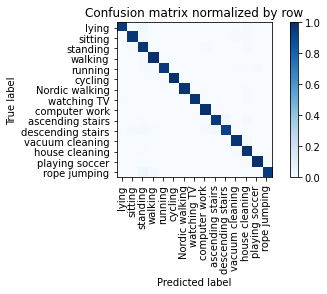

Overall accuracy: 0.977

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.991      0.997      0.994      0.130        583|	 standing: 0.002,	sitting: 0.002,	
          walking       0.990      0.994      0.992      0.109        490|	 standing: 0.006,	rope jumping: 0.000,	
   house cleaning       0.946      0.980      0.963      0.088        394|	 vacuum cleaning: 0.008,	playing soccer: 0.005,	
          sitting       0.975      0.970      0.973      0.081        365|	 standing: 0.014,	house cleaning: 0.008,	
            lying       0.997      0.948      0.972      0.081        363|	 standing: 0.036,	house cleaning: 0.008,	
   Nordic walking       1.000      0.983      0.991      0.077        345|	 house cleaning: 0.006,	descending stairs: 0.003,	
         standing       0.900      0.974      0.935      0.076        342|	 house cleaning: 0.009,	computer work: 0.009,	
          cycling       1.000      0.997      0.998

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

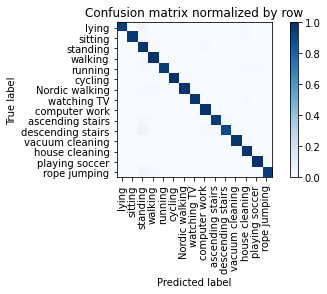

Overall accuracy: 0.975

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.990      0.997      0.993      0.131        586|	 standing: 0.002,	sitting: 0.002,	
          walking       0.982      0.992      0.987      0.109        490|	 standing: 0.008,	rope jumping: 0.000,	
   house cleaning       0.953      0.982      0.967      0.087        388|	 vacuum cleaning: 0.008,	playing soccer: 0.005,	
          sitting       0.989      0.967      0.978      0.081        365|	 standing: 0.019,	house cleaning: 0.008,	
            lying       0.997      0.945      0.970      0.081        363|	 standing: 0.041,	house cleaning: 0.008,	
   Nordic walking       1.000      0.980      0.990      0.077        344|	 walking: 0.009,	standing: 0.009,	
         standing       0.864      0.982      0.919      0.076        342|	 computer work: 0.009,	house cleaning: 0.006,	
  vacuum cleaning       0.975      0.978      0.976      0.071     

unseen:   0%|          | 0/60 [00:00<?, ?batch/s]

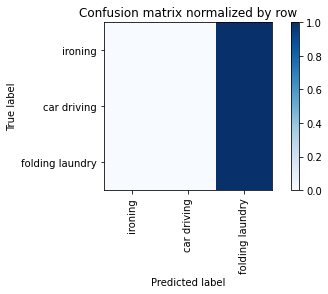

Overall accuracy: 0.254

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       1.000      0.000      0.001      0.607       2330|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.253      1.000      0.404      0.253        973|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.140        537|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.671      0.254      0.103        1.0       3840|	      

{'accuracy': 0.25364583333333335, 'precision': 0.4178171398801771, 'recall': 0.3334763948497854, 'f1': 0.13508788446444306}
============== Overall Unseen Classes Performance ==============


accuracy     0.417957
precision    0.523124
recall       0.472728
f1           0.393249
dtype: float64

In [ ]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'],weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', print_report=True, loss_alpha=0.0001)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    #plot_curves(train_df)
    
    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],   phase='unseen', loss_alpha=0.0001)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
